In [118]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
import datetime as dt
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin

In [119]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [207]:
#체크포인트 폴더 만들기
folder = os.getcwd()
folderlist = os.listdir(folder)
count = 0
if 'checkpoint' not in folderlist:
    os.mkdir('checkpoint')

In [220]:
#파일 불러오기
#filelist = 학습 돌릴 폴더안의 파일들
filelist = os.listdir(folderlist := 'TEST_DATA_IND')
if '.ipynb_checkpoints' in filelist:
    filelist.remove('.ipynb_checkpoints')
print(len(filelist))

80


In [221]:
df = pd.read_csv('./'+folderlist+'/'+filelist[0],index_col=0)
print(df)

            EDA   TEMP  listen  stay  talk             Current Time  IBI
0      0.000000  0.904       0     1     0  2020-08-21 11:27:32.000  NaN
1      0.074827  0.904       0     1     0  2020-08-21 11:27:32.250  NaN
2      0.105529  0.904       0     1     0  2020-08-21 11:27:32.500  NaN
3      0.144250  0.904       0     1     0  2020-08-21 11:27:32.750  NaN
4      0.186484  0.904       0     1     0  2020-08-21 11:27:33.000  NaN
...         ...    ...     ...   ...   ...                      ...  ...
11194  0.704052  0.744       0     1     0  2020-08-21 13:30:41.250  NaN
11195  0.703600  0.744       0     1     0  2020-08-21 13:30:41.500  NaN
11196  0.700656  0.744       0     1     0  2020-08-21 13:30:41.750  NaN
11197  0.699411  0.712       0     1     0  2020-08-21 13:30:42.000  NaN
11198  0.700204  0.712       0     1     0  2020-08-21 13:30:42.250  NaN

[11199 rows x 7 columns]


In [246]:
#csv파일을 불러오고 라벨과 데이터로 나눈뒤 텐서형으로 정리
#EDA에 빈 값이 많아 EDA 빈값 ROW 제거
def readfile(file, num = int):
    df = pd.read_csv('./TEST_DATA_IND/' + file[num], index_col = 0)
    df_non = df
    df.set_index("Current Time", inplace = True)
    """ 
    df = df[df['EDA'] != 0]
    df = df[df['TEMP'] != 0]
    """
    df_all = df
    df_data_all = df_all.iloc[:, :-1]
    df_label_all = df_all.iloc[:, -1:]
    df_data_all = df_data_all.values
    df_label_all = df_label_all.values
    df_data_all = torch.Tensor(df_data_all).float()
    df_label_all = torch.Tensor(df_label_all).float()
    
    df_data_all = torch.reshape(df_data_all, (df_data_all.shape[0],
                                                  1, df_data_all.shape[1]))
    
    df = df[df['IBI'].isnull()==False]
    df_data = df.iloc[:, :-1]
    df_label = df.iloc[:, -1:]
    df_data = df_data.values
    df_label = df_label.values
    df_data = torch.Tensor(df_data).float()
    df_label = torch.Tensor(df_label).float()
    
    df_data = torch.reshape(df_data, (df_data.shape[0],
                                                  1, df_data.shape[1]))
    
    return df_data_all, df_label_all, df_data, df_label, df_non

In [249]:
df_data_all, df_label_all, df_data, df_label, df_non = readfile(filelist, 0)

AttributeError: 'Tensor' object has no attribute 'index'

In [165]:
class LSTM(BaseEstimator, nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x) :
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out    

In [189]:
# 변수값 설정
num_epochs = 500
lr = 0.0001

input_size=5
hidden_size=2
num_layers=1
seq_length = 5

num_classes=1
model = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)
learning_rate = 0.001
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [190]:
loss_list = []
checkpoint_num = 1 
checkpoint_epoch = 0
list=[]
"""
1번째 for문 체크포인트불러오기
2번째 for문 에포크에 따른 학습 실행

"""

for num_sess in range(1):
    os.remove(f"./checkpoint/checkpoint-{num_sess+1}.pt")
    checkroute = f"./checkpoint/checkpoint-{num_sess}.pt"
    df_data_all, df_label_all, df_data, df_label, df = readfile(filelist, num_sess)
    
    if checkpoint_num > 1:
        checkpoint = torch.load(checkroute)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        checkpoint_epoch = checkpoint["epoch"]
        checkpoint_description = checkpoint["description"]

    for epoch in range(checkpoint_epoch+1, checkpoint_epoch + num_epochs+1) :
        cost = 0.0
        outputs = model(df_data)
        optimizer.zero_grad()
        loss = criterion(outputs, df_label)
        list.append(outputs)
        loss_list.append(loss.item())
        loss.backward()
        
        optimizer.step()
        if epoch % 50 == 0 :
            print(f'{num_sess} file\'s loss -> Epoch : {epoch}, loss : {loss.item():1.5f}')
        if (epoch + 1) % 300 == 0:
            checkpoint_num = checkpoint_num +1
            torch.save(
                {
                    "model": "LSTM",
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    'loss': loss,
                    "description": f"CustomModel 체크포인트-{num_sess+1}",
                },
                f"./checkpoint/checkpoint-{num_sess+1}.pt",
            )
            

0 file's loss -> Epoch : 50, loss : 0.01899
0 file's loss -> Epoch : 100, loss : 0.01793
0 file's loss -> Epoch : 150, loss : 0.01780
0 file's loss -> Epoch : 200, loss : 0.01756
0 file's loss -> Epoch : 250, loss : 0.01706
0 file's loss -> Epoch : 300, loss : 0.01646
0 file's loss -> Epoch : 350, loss : 0.01587
0 file's loss -> Epoch : 400, loss : 0.01558
0 file's loss -> Epoch : 450, loss : 0.01549
0 file's loss -> Epoch : 500, loss : 0.01544


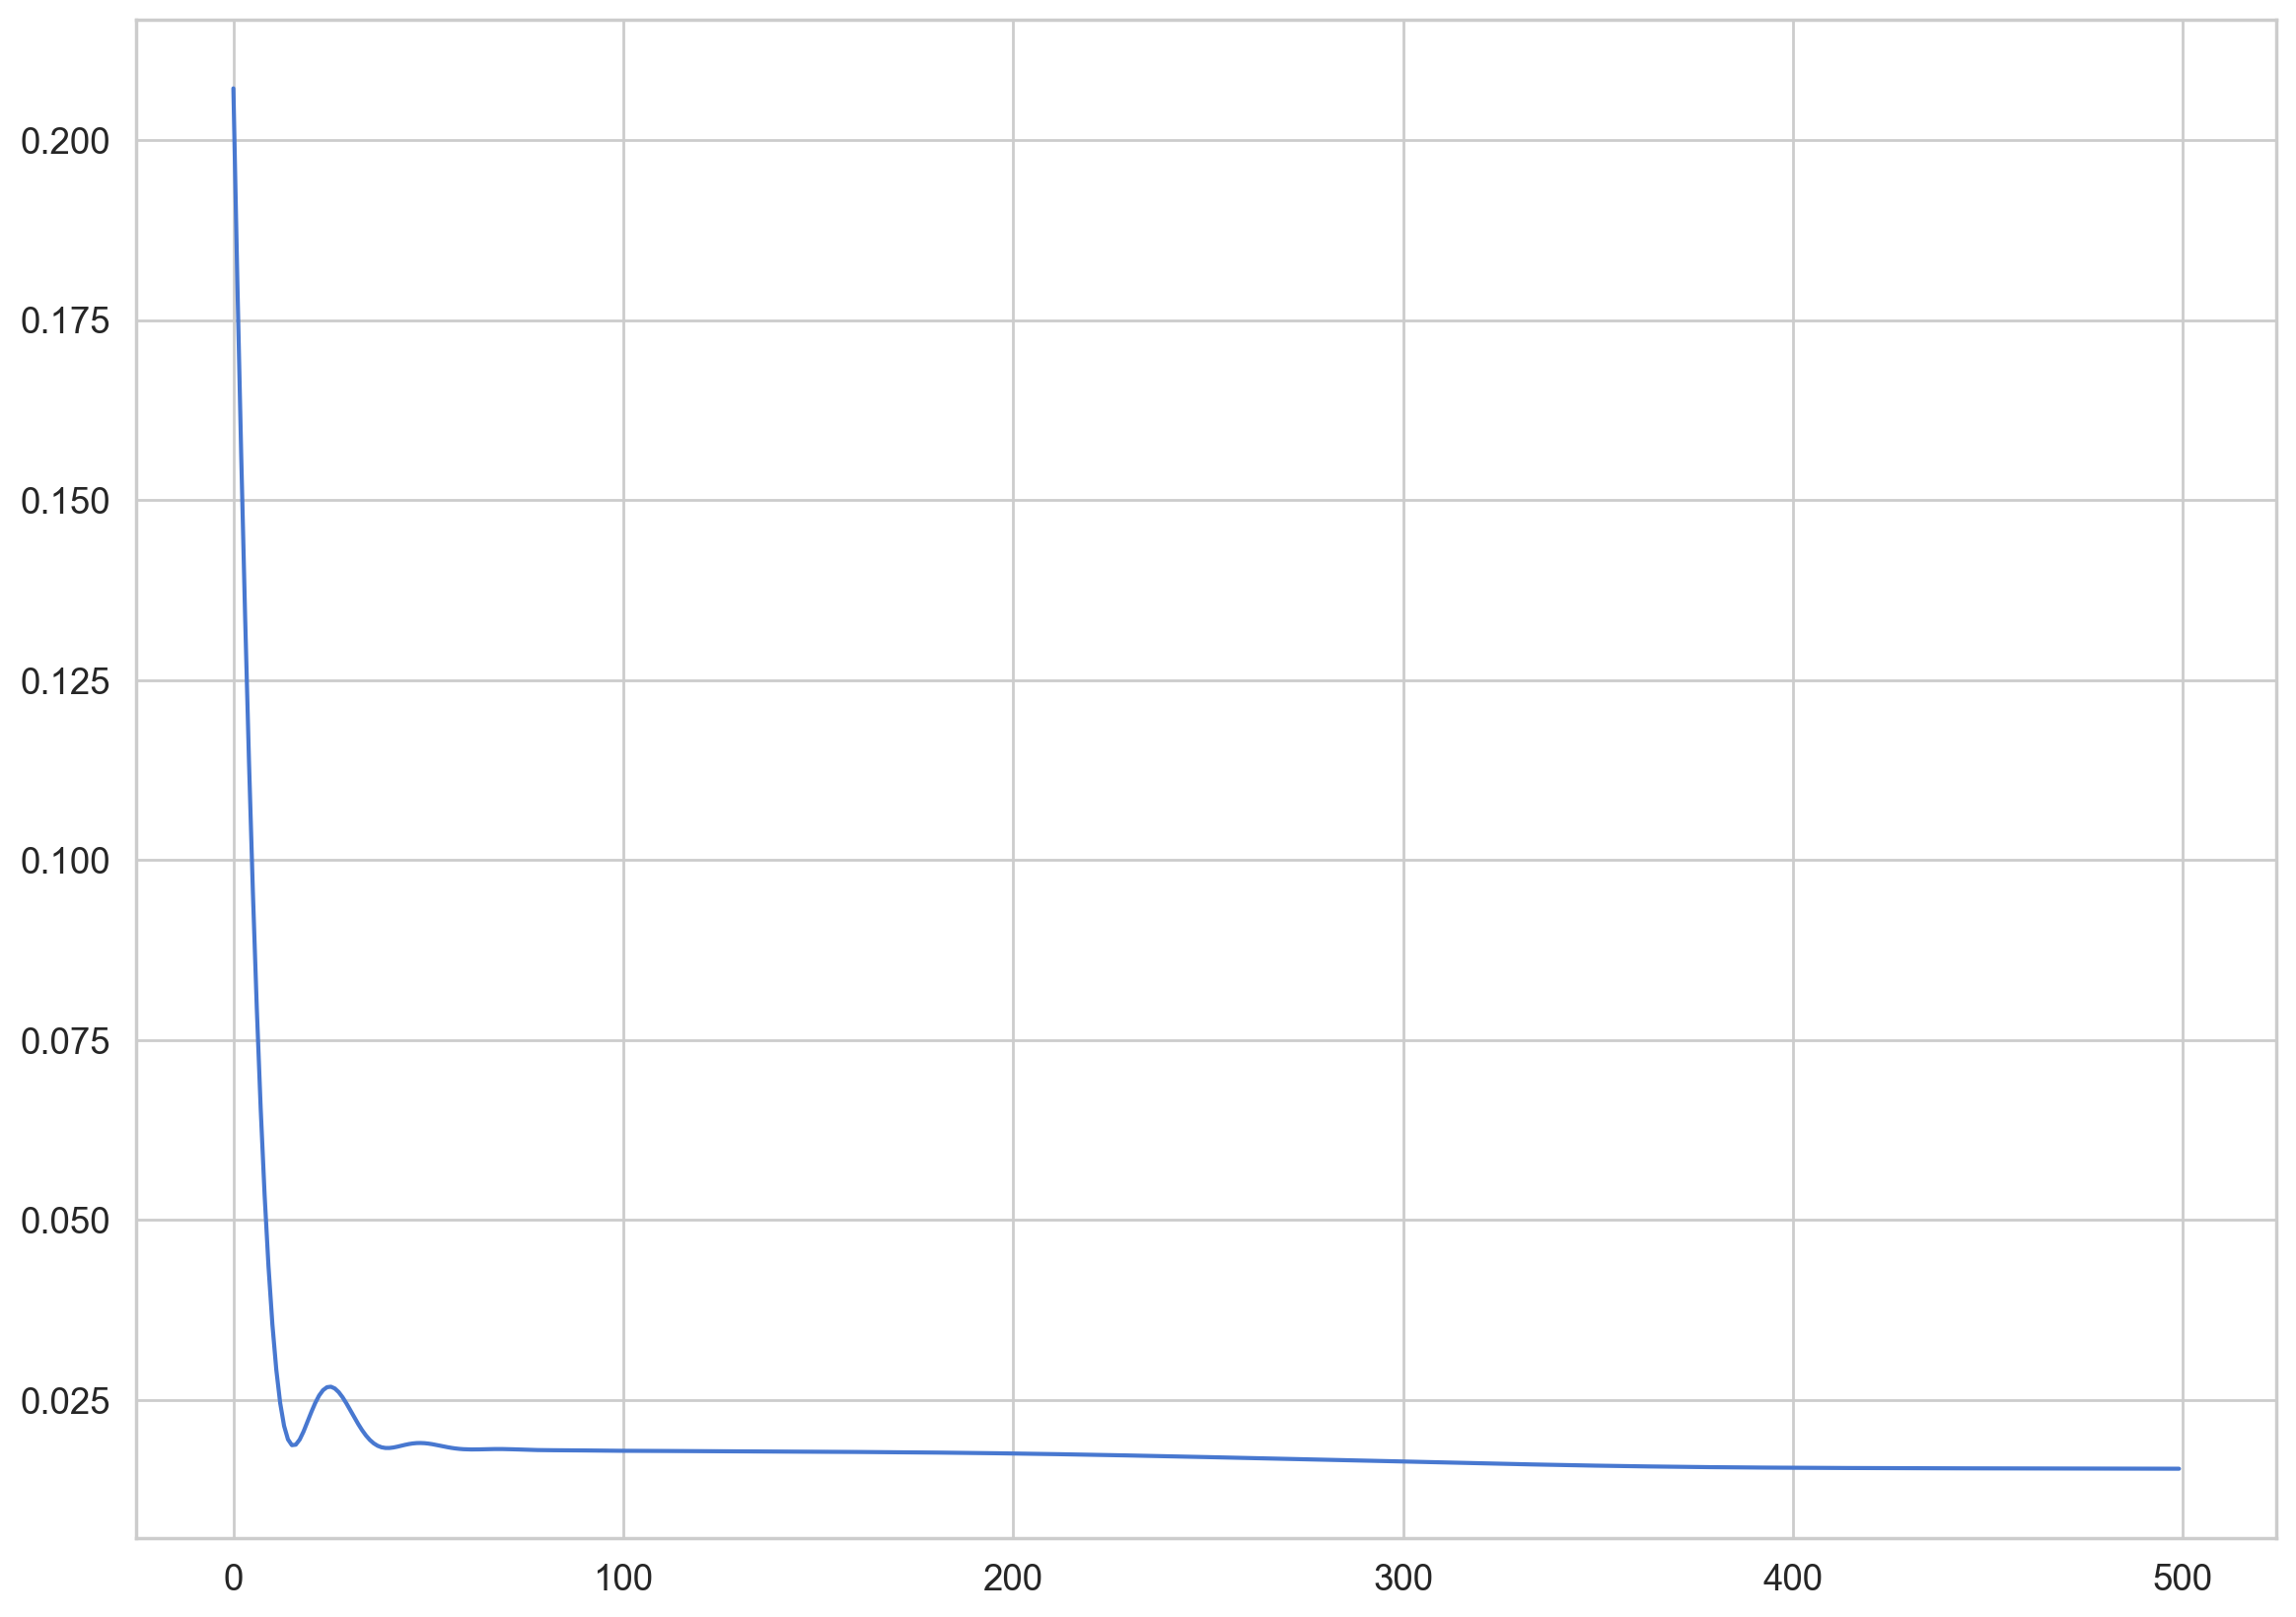

In [191]:
plt.plot(loss_list)
plt.show()

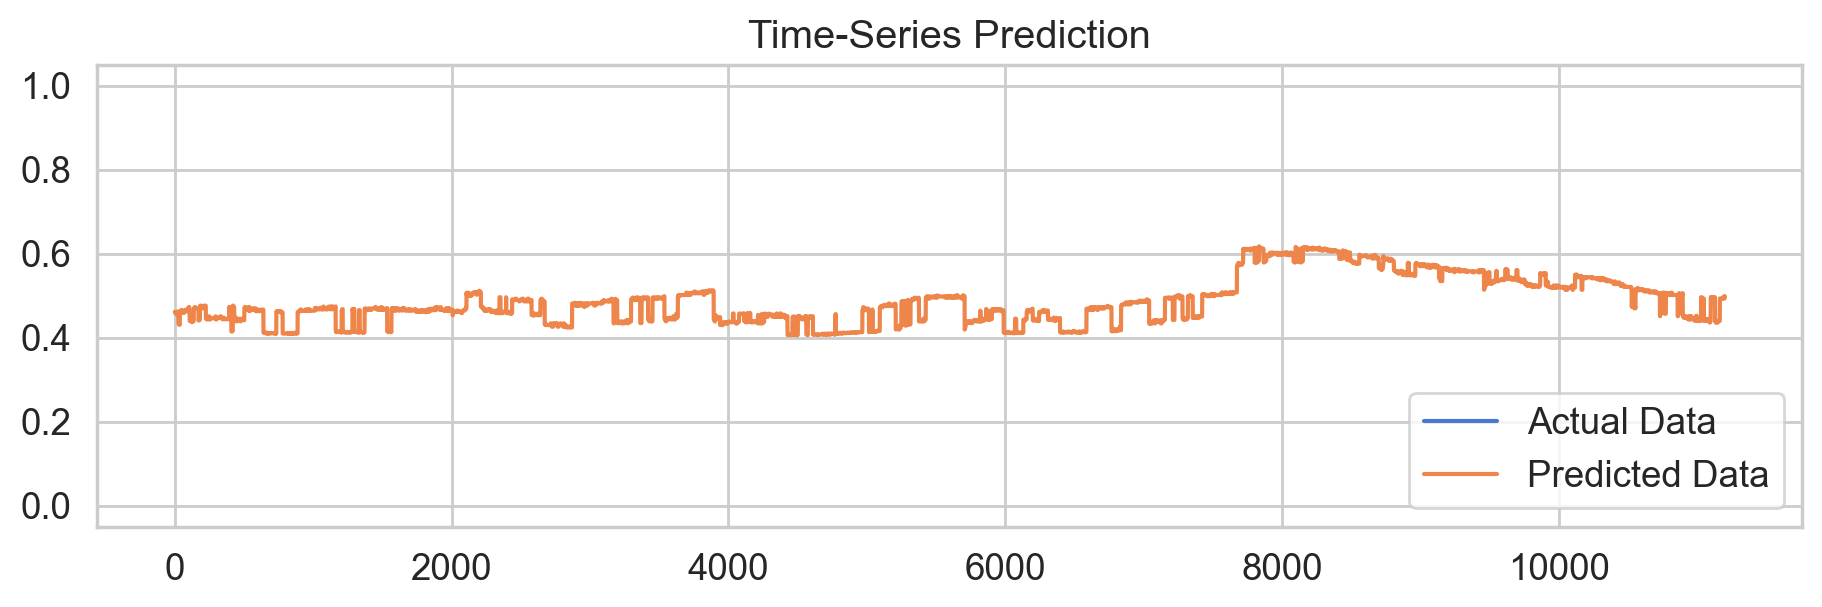

In [206]:
"""df_data_all = df_data_all[:100]
df_label_all = df_label_all[:100]"""
train_predict = model(df_data_all)
predicted = train_predict.data.numpy()
label_df = df_label_all.data.numpy()

plt.figure(figsize=(11, 3))

plt.plot(label_df, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [205]:
df_pre = pd.DataFrame(predicted)
df_pre = df_pre.iloc[:10176]
df_time = df.index
print(type(df_time))

<class 'pandas.core.indexes.base.Index'>


In [197]:
print(predicted.dtype)
print(len(label_df))
print(len(df))

float32
11199
10176


In [198]:
predicted.iloc[:10176]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'